In [167]:
import sys
sys.path.append("../")


import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from patsy import dmatrices
from openpyxl import load_workbook

from linearmodels import PanelOLS


from library import print_statistics

In [168]:
def coef_with_stars(coef, pvalue):
    coef = round(coef, 2)
    if pvalue >.05:
        coef = str(coef)
    if pvalue <= .05:
        coef = str(coef) + '*'
    if pvalue <= .01:
        coef = coef + '*'
    if pvalue <= .001:
        coef = coef + '*'
    return(coef)
test = coef_with_stars(9.1568, 0.8523)
test

'9.16'

In [222]:
def bonferroni(n_tests, coef, pvalue):
    coef = round(coef, 2)
    if pvalue >(.05/n_tests):
        coef = str(coef)
    if pvalue <= (.05/n_tests):
        coef = str(coef) + '*'
    if pvalue <= (.01/n_tests):
        coef = coef + '*'
    if pvalue <= (.001/n_tests):
        coef = coef + '*'
    return(coef)
test = bonferroni(4, .1, .005)
test

'0.1*'

In [169]:
def format_se(se):
    if se < .005:
        se = '(0.00)'
    else:
        se = '(' + str(round(se, 2)) + ')'
    return se
test = format_se(.0053)
test

'(0.01)'

In [170]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/Who Needs Rules/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid_subject.csv'),
                  sep=",", low_memory= False)
#load(data)
print(data[data.doi == True].district.nunique())
data = data[data.doi == True]

data.sample()

data['doi_year'] = np.where((data.doi_year == 2015), np.nan, data.doi_year) #drop first implementer (one district)

822


In [171]:
data.doi_year.value_counts()

2017.0    189602
2018.0     44254
2016.0     41794
2019.0      8971
Name: doi_year, dtype: int64

## Drop English 2, US History, and 8th grade science

In [172]:
data = data[(data.test != 'eng2_avescore') & (data.test != 'us_avescore') & (data.test != 's_8th_avescore')]

# Create year-test fixed effects

In [173]:
data['test_by_year'] = data['test'] + data['year'].map(str)

# Create trend and nonparametric variables

## Phase-in Effect - yearpost

In [174]:
data['yearpost'] = np.where(data.year > data.doi_year, data.year - data.doi_year, 0)
data[['year', 'doi_year', 'yearpost']].sample(10)

,year,doi_year,yearpost
257725,2014,2017.0,0.0
205836,2012,2018.0,0.0
94099,2016,2017.0,0.0
288231,2016,2017.0,0.0
249952,2014,2016.0,0.0
253898,2014,2017.0,0.0
51478,2014,2017.0,0.0
388445,2017,2017.0,0.0
103526,2016,2017.0,0.0
305898,2016,2016.0,0.0


In [175]:
data.yearpost.value_counts()

0.0    196463
1.0     31546
2.0     26643
3.0      4983
Name: yearpost, dtype: int64

## Pretrends - yearpre

In [176]:

data['yearpre'] = np.where(data.year <= data.doi_year, data.year - data.doi_year, 0)
data[['year', 'doi_year', 'yearpost', 'yearpre']].sample(5)

,year,doi_year,yearpost,yearpre
47504,2014,2017.0,0.0,-3.0
144666,2018,2017.0,1.0,0.0
379246,2019,2017.0,2.0,0.0
342983,2018,2017.0,1.0,0.0
319593,2017,2016.0,1.0,0.0


In [177]:
data.yearpre.value_counts()

 0.0    98430
-1.0    32224
-2.0    31991
-3.0    31762
-4.0    31526
-5.0    26857
-6.0     5877
-7.0      968
Name: yearpre, dtype: int64

## Non-parametric fixed effects for years pre and post - pre# and post#

In [178]:
data['pre5'] = np.where(data.yearpre <= -5, 1, 0)
data['pre4'] = np.where(data.yearpre == -4, 1, 0)
data['pre3'] = np.where(data.yearpre == -3, 1, 0)
data['pre2'] = np.where(data.yearpre == -2, 1, 0)
data['pre1'] = np.where(data.yearpre == -1, 1, 0)
data['pre0'] = np.where(data.yearpre == 0, 1, 0)
data['post1'] = np.where(data.yearpost == 1, 1, 0)
data['post2'] = np.where(data.yearpost == 2, 1, 0)
data['post3'] = np.where(data.yearpost == 3, 1, 0)


In [179]:
#convert year to datetime
df = data.reset_index()
df['year'] = pd.to_datetime(df['year'], format='%Y')
#add column year to index
df = data.set_index(['year', 'campus'])
#swap indexes
df.index = df.index.swaplevel(0,1)
df[['district', 'doi_year','treatpost']].sample(5)

,,district,doi_year,treatpost
campus,year,,,
43904041,2016,43904,2017.0,False
220901137,2014,220901,2016.0,False
220901123,2016,220901,2016.0,False
111901042,2012,111901,2017.0,False
227901141,2017,227901,2017.0,False


# Specifications

In [180]:
# Get table ready
file = table_path + 'table3_gdid_and_event.xlsx'
wb = load_workbook(file)
ws = wb.active

## Simple GDID

In [181]:
test = pd.Categorical(df.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
ws.cell(row= 3, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 4, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2179
Estimator:                   PanelOLS   R-squared (Between):             -0.2166
No. Observations:              259635   R-squared (Within):               0.2179
Date:                Thu, Dec 19 2019   R-squared (Overall):              0.0346
Time:                        08:04:34   Log-likelihood                -1.924e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      578.57
Entities:                        6102   P-value                           0.0000
Avg Obs:                       42.549   Distribution:              F(122,253411)
Min Obs:                       1.0000                                           
Max Obs:                       120.00   F-statistic (robust):             299.23
                            

### GDID Placebo

In [ ]:
test = pd.Categorical(df.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
ws.cell(row= 3, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 4, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])

## GDID with Trends

In [182]:
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
#mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + TimeEffects + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
#intercept = res.params['Intercept']
jump = res.params['treatpost[T.True]']
preslope = res.params['yearpre']
preslope_se = res.std_errors['yearpre']
postslope = res.params['yearpost']
post_slope = res.std_errors['yearpost']
ws.cell(row= 6, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 7, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])
ws.cell(row= 8, column= 2).value = coef_with_stars(res.params['yearpost'], res.pvalues['yearpost'])
ws.cell(row= 9, column= 2).value = format_se(res.std_errors['yearpost'])
ws.cell(row= 10, column= 2).value = coef_with_stars(res.params['yearpre'], res.pvalues['yearpre'])
ws.cell(row= 11, column= 2).value = format_se(res.std_errors['yearpre'])
wb.save(file)

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2180
Estimator:                   PanelOLS   R-squared (Between):             -0.2170
No. Observations:              259635   R-squared (Within):               0.2180
Date:                Thu, Dec 19 2019   R-squared (Overall):              0.0343
Time:                        08:05:02   Log-likelihood                -1.924e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      569.58
Entities:                        6102   P-value                           0.0000
Avg Obs:                       42.549   Distribution:              F(124,253409)
Min Obs:                       1.0000                                           
Max Obs:                       120.00   F-statistic (robust):             295.85
                            

# Non-parametric event study

In [183]:
mod = PanelOLS.from_formula('score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + pre1 + post1 + post2 + post3 + students_hisp + students_num + C(test_by_year) + EntityEffects', df)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
nonparametric = []
nonparametric_se = []
for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'pre0', 'post1', 'post2', 'post3']:
    nonpar = 0
    nonpar_se = 0
    if coef != 'pre0':
        nonpar = res.params[coef]
        nonpar_se = res.std_errors[coef]
    nonparametric.append(nonpar)
    nonparametric_se.append(nonpar_se)
print(nonparametric)
row = 3
for coef in ['post3', 'post2', 'post1', 'pre1', 'pre2', 'pre3', 'pre4', 'pre5']:
    ws.cell(row= row, column= 4).value = coef_with_stars(res.params[coef], res.pvalues[coef])
    row = row + 1
    ws.cell(row= row, column= 4).value = format_se(res.std_errors[coef])  
    row = row + 1
wb.save(file)

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2180
Estimator:                   PanelOLS   R-squared (Between):             -0.2171
No. Observations:              259635   R-squared (Within):               0.2180
Date:                Thu, Dec 19 2019   R-squared (Overall):              0.0343
Time:                        08:05:28   Log-likelihood                -1.924e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      547.68
Entities:                        6102   P-value                           0.0000
Avg Obs:                       42.549   Distribution:              F(129,253404)
Min Obs:                       1.0000                                           
Max Obs:                       120.00   F-statistic (robust):             284.36
                            

In [184]:
coef_df = pd.DataFrame({'coef': nonparametric,
                        'err': nonparametric_se,
                        'year': [-5, -4, -3, -2, -1,0 , 1, 2, 3]
                       })
coef_df['lb'] = coef_df.coef - (1.96*coef_df.err)
coef_df['ub'] = coef_df.coef + (1.96*coef_df.err)
coef_df

,coef,err,year,lb,ub
0,0.003428,0.038410,-5,-0.071855,0.078710
1,0.008783,0.031070,-4,-0.052115,0.069680
2,0.025071,0.024544,-3,-0.023036,0.073178
3,0.018132,0.017307,-2,-0.015790,0.052055
4,0.005830,0.009536,-1,-0.012861,0.024521
5,0.000000,0.000000,0,0.000000,0.000000
6,-0.023620,0.010281,1,-0.043771,-0.003470
7,-0.050868,0.019848,2,-0.089770,-0.011966
8,-0.077382,0.030802,3,-0.137754,-0.017010


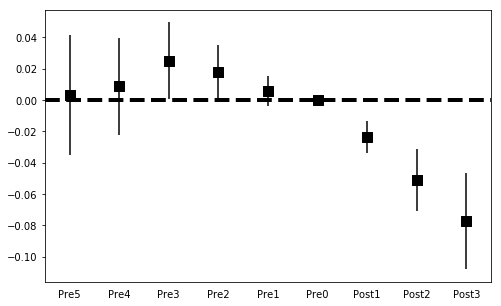

In [200]:
fig, ax = plt.subplots(figsize=(8, 5))
coef_df.plot(x='year', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['Pre5', 'Pre4', 'Pre3', 'Pre2', 'Pre1', 'Pre0', 'Post1', 'Post2', 'Post3'], 
                       rotation=0)
#ax.set_title('Impact on Student Achievement - Event Study Coefficients', fontsize = 16)

# Create graph (look up how to use predicted values)


In [186]:
years = [-5, -4, -3, -2, -1, 0, 1, 2, 3]
parametric = []
parametric_lb = []
for year in years:
    par = 0
    if year < 0 :
        par = (year * preslope)
    if year > 0 :
        par = jump + (year * postslope)
    parametric.append(par)
parametric

[-0.030244200986660197,
 -0.024195360789328157,
 -0.018146520591996118,
 -0.012097680394664079,
 -0.006048840197332039,
 0,
 -0.019998024546838647,
 -0.041130358972276,
 -0.062262693397713356]

In [187]:
nonparametric

[0.0034277098202160905,
 0.00878268612544214,
 0.025071194580884026,
 0.01813222539496863,
 0.005830171702650377,
 0,
 -0.023620482994153064,
 -0.0508679870054492,
 -0.07738175618781648]

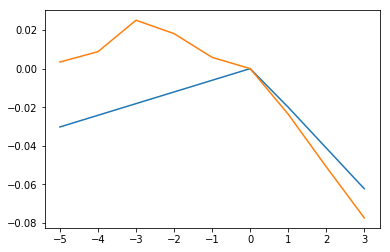

In [188]:
plt.plot(years, parametric)
plt.plot(years, nonparametric)

# Table by Subject

In [217]:
subjects = ['m_3rd_avescore', 'r_3rd_avescore',
            'm_4th_avescore', 'r_4th_avescore', 
            'm_5th_avescore', 'r_5th_avescore', 
            'm_6th_avescore', 'r_6th_avescore',
            'm_7th_avescore', 'r_7th_avescore',
            'm_8th_avescore', 'r_8th_avescore',
            'alg_avescore', 'bio_avescore', 'eng1_avescore']

In [224]:
# All Subject Table
file = table_path + 'tableA_effect_by_subject.xlsx'
wb = load_workbook(file)
ws = wb.active

col = 3
for subject in subjects:
    
    df_sub = df[df.test == subject]
    test = pd.Categorical(df_sub.test)
    
    # GDID
    mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_hisp + students_num + C(test_by_year) + EntityEffects', df_sub)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    ws.cell(row= 4, column= col).value = bonferroni(len(subjects), res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
    ws.cell(row= 5, column= col).value = format_se(res.std_errors['treatpost[T.True]'])

    # GDID with Trend
    mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + C(test_by_year) + EntityEffects', df_sub)
    #mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + TimeEffects + EntityEffects', df_sub)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    jump = res.params['treatpost[T.True]']
    preslope = res.params['yearpre']
    preslope_se = res.std_errors['yearpre']
    postslope = res.params['yearpost']
    post_slope = res.std_errors['yearpost']
    ws.cell(row= 7, column= col).value = bonferroni(len(subjects), res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
    ws.cell(row= 8, column= col).value = format_se(res.std_errors['treatpost[T.True]'])
    ws.cell(row= 9, column= col).value = bonferroni(len(subjects), res.params['yearpost'], res.pvalues['yearpost'])
    ws.cell(row= 10, column= col).value = format_se(res.std_errors['yearpost'])
    ws.cell(row= 11, column= col).value = bonferroni(len(subjects), res.params['yearpre'], res.pvalues['yearpre'])
    ws.cell(row= 12, column= col).value = format_se(res.std_errors['yearpre'])
    wb.save(file)

    # Event Study
    mod = PanelOLS.from_formula('score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + pre1 + post1 + post2 + post3 + students_hisp + students_num + C(test_by_year) + EntityEffects', df_sub)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    nonparametric = []
    nonparametric_se = []
    for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'pre0', 'post1', 'post2', 'post3']:
        nonpar = 0
        nonpar_se = 0
        if coef != 'pre0':
            nonpar = res.params[coef]
            nonpar_se = res.std_errors[coef]
        nonparametric.append(nonpar)
        nonparametric_se.append(nonpar_se)
    print(nonparametric)
    row = 14
    for coef in ['post3', 'post2', 'post1', 'pre1', 'pre2', 'pre3', 'pre4', 'pre5']:
        ws.cell(row= row, column= col).value = bonferroni(len(subjects), res.params[coef], res.pvalues[coef])
        row = row + 1
        ws.cell(row= row, column= col).value = format_se(res.std_errors[coef])  
        row = row + 1
    wb.save(file)
    col = col + 1

[0.02209187618900858, 0.0071850869055396956, 0.0713380615644899, 0.05791217709151354, 0.023643938995645118, 0, -0.03914634083635471, -0.0924648829476749, -0.1652757638003539]
[0.09945302146645461, 0.0808912350085835, 0.08051836425208991, 0.04466933862452123, 0.017880605098113057, 0, -0.02920445999847929, -0.08718356510350332, -0.12713030406418416]
[0.02844253922546972, 0.046504219344653513, 0.06931884627713465, 0.05410317695780714, 0.0148032315194265, 0, -0.038090651268160934, -0.06841482988285034, -0.1167178303398707]
[0.024609810170060406, 0.022391409143582463, 0.018107999045659042, 0.012275207763749785, 0.013543679692039054, 0, -0.010981948440599486, -0.03036123750686126, -0.03239731226887272]
[-0.06216093813030479, -0.02792371121183818, 0.014630980473575257, 0.013439603024304235, 0.00481189822838329, 0, -0.03366960660762075, -0.05301713212770044, -0.10582358818481206]
[-0.052138822503633886, 0.010875829278732563, 0.024228357243255453, -0.017218831016421438, -0.004380904443660492, 0

# Effects without 6th Grade Math

In [225]:
file = table_path + 'tableA2_gdid_and_event.xlsx'
wb = load_workbook(file)
ws = wb.active


df_limited = df[df.test != 'm_6th_avescore']

test = pd.Categorical(df_limited.test)
mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + students_hisp + students_num + C(test_by_year) + EntityEffects', df_limited)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
ws.cell(row= 3, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 4, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])

mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + C(test_by_year) + EntityEffects', df_limited)
#mod = PanelOLS.from_formula('score_std ~ + 1 + treatpost + yearpost + yearpre + students_hisp + students_num + TimeEffects + EntityEffects', df_limited)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
#intercept = res.params['Intercept']
jump = res.params['treatpost[T.True]']
preslope = res.params['yearpre']
preslope_se = res.std_errors['yearpre']
postslope = res.params['yearpost']
post_slope = res.std_errors['yearpost']
ws.cell(row= 6, column= 2).value = coef_with_stars(res.params['treatpost[T.True]'], res.pvalues['treatpost[T.True]'])
ws.cell(row= 7, column= 2).value = format_se(res.std_errors['treatpost[T.True]'])
ws.cell(row= 8, column= 2).value = coef_with_stars(res.params['yearpost'], res.pvalues['yearpost'])
ws.cell(row= 9, column= 2).value = format_se(res.std_errors['yearpost'])
ws.cell(row= 10, column= 2).value = coef_with_stars(res.params['yearpre'], res.pvalues['yearpre'])
ws.cell(row= 11, column= 2).value = format_se(res.std_errors['yearpre'])
wb.save(file)

mod = PanelOLS.from_formula('score_std ~ + 1 + pre5 + pre4 + pre3 + pre2 + pre1 + post1 + post2 + post3 + students_hisp + students_num + C(test_by_year) + EntityEffects', df_limited)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)
nonparametric = []
nonparametric_se = []
for coef in ['pre5', 'pre4', 'pre3', 'pre2', 'pre1', 'pre0', 'post1', 'post2', 'post3']:
    nonpar = 0
    nonpar_se = 0
    if coef != 'pre0':
        nonpar = res.params[coef]
        nonpar_se = res.std_errors[coef]
    nonparametric.append(nonpar)
    nonparametric_se.append(nonpar_se)
print(nonparametric)
row = 3
for coef in ['post3', 'post2', 'post1', 'pre1', 'pre2', 'pre3', 'pre4', 'pre5']:
    ws.cell(row= row, column= 4).value = coef_with_stars(res.params[coef], res.pvalues[coef])
    row = row + 1
    ws.cell(row= row, column= 4).value = format_se(res.std_errors[coef])  
    row = row + 1
wb.save(file)

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2201
Estimator:                   PanelOLS   R-squared (Between):             -0.1750
No. Observations:              246320   R-squared (Within):               0.2201
Date:                Thu, Dec 19 2019   R-squared (Overall):              0.0498
Time:                        10:35:58   Log-likelihood                -1.813e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      594.36
Entities:                        6102   P-value                           0.0000
Avg Obs:                       40.367   Distribution:              F(114,240104)
Min Obs:                       1.0000                                           
Max Obs:                       112.00   F-statistic (robust):             308.09
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2202
Estimator:                   PanelOLS   R-squared (Between):             -0.1751
No. Observations:              246320   R-squared (Within):               0.2202
Date:                Thu, Dec 19 2019   R-squared (Overall):              0.0496
Time:                        10:36:18   Log-likelihood                -1.813e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      584.47
Entities:                        6102   P-value                           0.0000
Avg Obs:                       40.367   Distribution:              F(116,240102)
Min Obs:                       1.0000                                           
Max Obs:                       112.00   F-statistic (robust):             304.32
                            

                          PanelOLS Estimation Summary                           
Dep. Variable:              score_std   R-squared:                        0.2203
Estimator:                   PanelOLS   R-squared (Between):             -0.1753
No. Observations:              246320   R-squared (Within):               0.2203
Date:                Thu, Dec 19 2019   R-squared (Overall):              0.0496
Time:                        10:36:38   Log-likelihood                -1.813e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      560.49
Entities:                        6102   P-value                           0.0000
Avg Obs:                       40.367   Distribution:              F(121,240097)
Min Obs:                       1.0000                                           
Max Obs:                       112.00   F-statistic (robust):             291.66
                            

# Heterogenous effects

In [194]:
### Generate variable for number of hispanic students in year before the district declares

In [195]:
data.teachers_turnover_ratio_d

17         8.1740
18         8.1740
19         8.1740
20         8.1740
21         8.1740
           ...   
405506    12.2000
405530     9.5111
405531     9.5111
405532    34.4752
405535    16.6722
Name: teachers_turnover_ratio_d, Length: 259635, dtype: float64

In [196]:
data_pre = data.loc[data.yearpost == -1]
data_pre = data_pre.rename(columns = {'students_hisp': 'students_hisp_pre',
                                     'teachers_turnover_ratio_d': 'teacher_turnover_pre'})
data_pre['low_avescores_pre'] = np.where(data_pre.avescores < data_pre.avescores.quantile(.25),1, 0)
data_pre['high_avescores_pre'] = np.where(data_pre.avescores > data_pre.avescores.quantile(.75),1,0)
data_pre = data_pre[['campus','students_hisp_pre', 'teacher_turnover_pre', 'low_avescores_pre', 'high_avescores_pre']]
data_hte = data.merge(data_pre, on = 'campus', how = 'left')
data_hte['majority_hisp_pre'] = np.where(data_hte.students_hisp_pre > .6, 1, 0)
data_hte['high_turnover'] = np.where(data_hte.teacher_turnover_pre > 20, 1, 0)
data_hte

,Unnamed: 0,campus,year,test,score,score_std,campname,campischarter,district,distname,...,pre0,post1,post2,post3,students_hisp_pre,teacher_turnover_pre,low_avescores_pre,high_avescores_pre,majority_hisp_pre,high_turnover
0,17,109901001,2012,alg_avescore,4069.0,0.081824,ABBOTT SCHOOL,N,109901,ABBOTT ISD,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
1,18,109901001,2012,bio_avescore,3852.0,-0.565197,ABBOTT SCHOOL,N,109901,ABBOTT ISD,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
2,19,109901001,2012,eng1_avescore,4076.0,0.603661,ABBOTT SCHOOL,N,109901,ABBOTT ISD,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
3,20,109901001,2012,m_3rd_avescore,1463.0,0.328504,ABBOTT SCHOOL,N,109901,ABBOTT ISD,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
4,21,109901001,2012,m_4th_avescore,1494.0,-0.521858,ABBOTT SCHOOL,N,109901,ABBOTT ISD,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
5,22,109901001,2012,m_5th_avescore,1545.0,-0.704759,ABBOTT SCHOOL,N,109901,ABBOTT ISD,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
6,23,109901001,2012,m_6th_avescore,1700.0,1.195277,ABBOTT SCHOOL,N,109901,ABBOTT ISD,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
7,24,109901001,2012,m_7th_avescore,1688.0,0.782115,ABBOTT SCHOOL,N,109901,ABBOTT ISD,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
8,25,109901001,2012,m_8th_avescore,1693.0,0.715399,ABBOTT SCHOOL,N,109901,ABBOTT ISD,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
9,26,109901001,2012,r_3rd_avescore,1466.0,0.689817,ABBOTT SCHOOL,N,109901,ABBOTT ISD,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0


In [197]:
data_pre = data.loc[data.year == 2016]
data_pre['rural_pre'] = np.where(data_pre.type_description == "RURAL", 1, 0)
data_pre['urban_pre'] = np.where(data_pre.type_description == "URBAN", 1, 0)
data_pre = data_pre[['campus','rural_pre', 'urban_pre']]
data_hte = data_hte.merge(data_pre, on = 'campus', how = 'left')
#df_hte[['students_hisp', 'students_hisp_pre', 'yearpost']].sample(5)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [198]:
#convert year to datetime
df_hte = data_hte.reset_index()
df_hte['year'] = pd.to_datetime(df_hte['year'], format='%Y')
#add column year to index
df_hte = data_hte.set_index(['year', 'campus'])
#swap indexes
df_hte.index = df_hte.index.swaplevel(0,1)
df_hte[['district', 'doi_year','treatpost',]].tail(20)

district  doi_year  treatpost
campus    year                               
84901009  2017     84901    2017.0      False
          2017     84901    2017.0      False
220901054 2017    220901    2016.0       True
          2017    220901    2016.0       True
220905104 2018    220905    2017.0       True
          2018    220905    2017.0       True
220916004 2019    220916    2017.0       True
          2019    220916    2017.0       True
220901139 2012    220901    2016.0      False
          2012    220901    2016.0      False
167902101 2012    167902    2017.0      False
          2012    167902    2017.0      False
          2012    167902    2017.0      False
          2012    167902    2017.0      False
122902001 2012    122902    2017.0      False
          2012    122902    2017.0      False
          2012    122902    2017.0      False
          2012    122902    2017.0      False
          2012    122902    2017.0      False
          2012    122902    2017.0      False

# Majority Hispanic

In [199]:
df_hte['treatpost_hisp'] = df_hte.treatpost * df_hte.majority_hisp_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_hisp + students_hisp + students_num + C(test) + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


ValueError: exog does not have full column rank.

In [ ]:
df_hte['treatpost_hisp'] = df_hte.treatpost * df_hte.majority_hisp_pre
df_hte['treatpost_hisp_rural'] = df_hte.treatpost_hisp * df_hte.rural_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_hisp + treatpost_hisp_rural + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

In [ ]:
df_hte[df_hte.majority_hisp_pre == 1][['district', 'type_description', 'majority_hisp_pre']]

# Rural

In [ ]:
df_hte['treatpost_rural'] = df_hte.treatpost * df_hte.rural_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_rural + rural_pre +  students_hisp + students_num  + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

# Performance

In [ ]:
df_hte['treatpost_low'] = df_hte.treatpost * df_hte.low_avescores_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_low + students_hisp + students_num  + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

In [ ]:
df_hte['treatpost_high'] = df_hte.treatpost * df_hte.high_avescores_pre
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_high+ students_hisp + students_num  + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

# Teacher Turnover

In [ ]:
df_hte['treatpost_turnover'] = df_hte.treatpost * df_hte.high_turnover
mod = PanelOLS.from_formula('avescores ~ + 1 + treatpost + treatpost_turnover + students_hisp + students_num + TimeEffects + EntityEffects', df_hte)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)